# Engineering Predictive Alpha Factors - TF Proprietary

This notebook illustrates the following steps:

1. Select the adjusted open, high, low, and close prices as well as the volume for all tickers from the Quandl Wiki data that you downloaded and simplified for the last milestone for the 2007-2016 time period. Looking ahead, we will use 2014-2016 as our 'out-of-sample' period to test the performance of a strategy based on a machine learning model selected using data from preceding periods.
2. Compute the dollar volume as the product of closing price and trading volume; then select the stocks with at least eight years of data and the lowest average daily rank for this metric. 
3. Compute daily returns and keep only 'inliers' with values between -100% and + 100% as a basic check against data error.
4. Now we're ready to compute financial features. The Alpha Factory Library listed among the resources below illustrates how to compute a broad range of those using pandas and TA-Lib. We will list a few examples; feel free to explore and evaluate the various TA-Lib indicators.
    - Compute **historical returns** for various time ranges such as 1, 3, 5, 10, 21 trading days, as well as longer periods like 2, 3, 6 and 12 months.
    - Use TA-Lib's **Bollinger Band** indicator to create features that anticipate **mean-reversion**.
    - Select some indicators from TA-Lib's **momentum** indicators family such as
        - the Average Directional Movement Index (ADX), 
        - the Moving Average Convergence Divergence (MACD), 
        - the Relative Strength Index (RSI), 
        - the Balance of Power (BOP) indictor, or 
        - the Money Flow Index (MFI).
    - Compute TA-Lib **volume** indicators like On Balance Volume (OBV) or the Chaikin A/D Oscillator (ADOSC)
    - Create volatility metrics such as the Normalized Average True Range (NATR).
    - Compute rolling factor betas using the five Fama-French risk factors for different rolling windows of three and 12 months (see resources below).
    - Compute the outcome variable that we will aim to predict, namely the 1-day forward returns.

## Usage tips

- If you experience resource constraints (suddenly restarting Kernel), increase the memory available for Docker Desktop (> Settings > Advanced). If this not possible or you experienced prolonged execution times, reduce the scope of the exercise. The easiest way to do so is to select fewer stocks or a shorter time period, or both.
- You may want to persist intermediate results so you can recover quickly in case something goes wrong. There's an example under the first 'Persist Results' subsection.

## Imports & Settings

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import timeit

import statsmodels.api as sm
# from statsmodels.regression.rolling import RollingOLS
from sklearn.preprocessing import scale

In [ ]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
import talib

Selecting previously unselected package libta-lib0.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 270 kB 9.3 MB/s 
  Created wheel for ta-lib: filename=TA_Lib-0.4.21-cp37-cp37m-linux_x86_64.whl size=1444981 sha256=702bb02c8b5d7d9096e054fc188201259deef0a851115189ed6b6a6c711c7bb3
  Stored in directory: /root/.cache/pip/wheels/32/3c/86/8dfaee7c11df54449f188172fcf66ae6d134f3118d0237df4a
Successfully built ta-lib


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

## Load saved data with returns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_hdf('drive/MyDrive/Colab Notebooks/data/returns.h5', 'data')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1402295 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZMH', Timestamp('2015-07-02 00:00:00'))
Data columns (total 15 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   open     1402295 non-null  float64
 1   high     1402295 non-null  float64
 2   low      1402295 non-null  float64
 3   close    1402295 non-null  float64
 4   volume   1402295 non-null  float64
 5   ret_01   1401795 non-null  float64
 6   ret_03   1400795 non-null  float64
 7   ret_05   1399795 non-null  float64
 8   ret_10   1397295 non-null  float64
 9   ret_21   1391795 non-null  float64
 10  ret_42   1381295 non-null  float64
 11  ret_63   1370795 non-null  float64
 12  ret_126  1339295 non-null  float64
 13  ret_252  1276295 non-null  float64
 14  ret_fwd  1402295 non-null  float64
dtypes: float64(15)
memory usage: 166.1+ MB


## Load Original Price Data

In [ ]:
DATA_STORE = Path('..', '01_set_up_environment_and_data', 'stock_prices.h5')

In [ ]:
with pd.HDFStore(DATA_STORE) as store:
    data = (store['df']
            .loc[idx[:, '2006':'2016'], :]  # slice 11 years from 2nd level of MultiIndex using pd.IndexSlice 
            .unstack('ticker') # move first index level 'ticker' into the columns
            .sort_index() 
            .fillna(method='ffill', limit=5) # fill up to five days of missing data with latest
            .stack('ticker') # move Index level 'ticker' back into the rows
            .swaplevel()     # swap levels of row index so we're back at (ticker, data)
            .dropna()        # remove missing values
            .sort_index())

In [ ]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7739201 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZUMZ', Timestamp('2016-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    7739201 non-null  float64
 1   high    7739201 non-null  float64
 2   low     7739201 non-null  float64
 3   close   7739201 non-null  float64
 4   volume  7739201 non-null  float64
dtypes: float64(5)
memory usage: 325.0+ MB


## Select 500 most-traded stocks prior to 2017

Compute the dollar volume as the product of the adjusted close price and the adjusted volume:

In [ ]:
dvol = data.close * data.volume
dvol.nlargest(10)

ticker  date      
BRK_A   2010-02-12    3.123828e+11
        2010-02-15    3.123828e+11
BRK_B   2010-02-11    1.766952e+11
BRK_A   2010-02-09    1.157659e+11
BRK_B   2010-02-10    1.026430e+11
        2010-02-09    1.010905e+11
        2010-02-01    9.902460e+10
        2010-02-08    8.902036e+10
        2010-02-05    8.635580e+10
        2010-02-04    8.125235e+10
dtype: float64

## Remove outliers based on daily returns

In [ ]:
daily_returns = data.groupby('ticker').close.pct_change() # returns computed based on closing prices
daily_returns.describe(percentiles=[.00001, .0001, .001, .999, .9999, .99999]).iloc[1:]

mean         0.000776
std          0.138084
min         -0.993615
0.001%      -0.706667
0.01%       -0.393309
0.1%        -0.191152
50%          0.000000
99.9%        0.230661
99.99%       0.580756
99.999%      1.783016
max        283.000000
Name: close, dtype: float64

**Finding Outliers**

In [ ]:
outliers = daily_returns[(daily_returns < daily_returns.quantile(.00001)) |
                         (daily_returns > daily_returns.quantile(.99999))]

In [ ]:
print(f'# Observations: {len(outliers):,.0f} | # Tickers: {len(outliers.index.unique("ticker")):,.0f}')

# Observations: 155 | # Tickers: 92


**Removing Outliers**

In [ ]:
data = data.drop(outliers.index.unique('ticker'), level='ticker')

## Find 500 most-traded Stocks, based on dollar volume

In [ ]:
top500 = (dvol.groupby(level='date')
          .rank(ascending=False)
          .unstack('ticker')
          .dropna(thresh=8*252, axis=1)
          .mean()
          .nsmallest(500))
to_drop = data.index.unique('ticker').difference(top500.index)

In [ ]:
data = data.drop(to_drop, level='ticker')
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1402795 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZMH', Timestamp('2015-07-06 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    1402795 non-null  float64
 1   high    1402795 non-null  float64
 2   low     1402795 non-null  float64
 3   close   1402795 non-null  float64
 4   volume  1402795 non-null  float64
dtypes: float64(5)
memory usage: 59.1+ MB


### Sample price data to illustrate factors

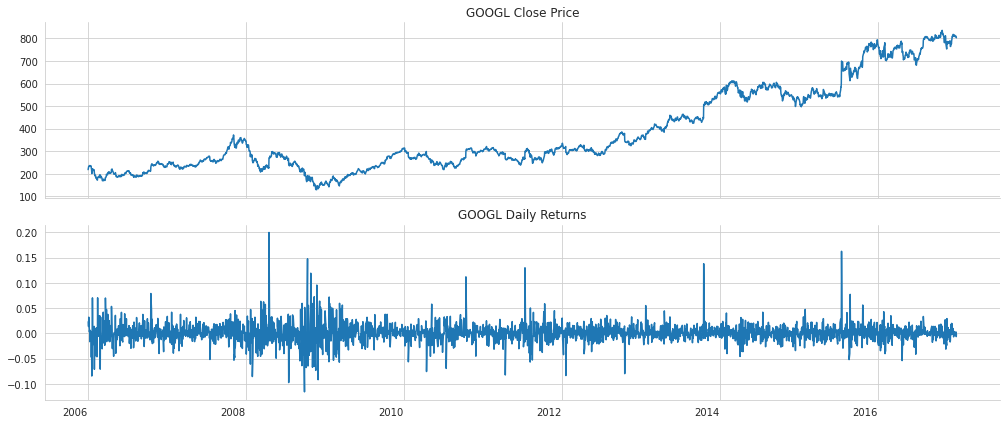

In [ ]:
ticker = 'GOOGL'

fig, axes = plt.subplots(nrows=2, figsize=(14, 6), sharex=True) # create figure with 2 axes
s = data.loc[ticker, 'close'] # select closing prices for ticker
s.plot(rot=0, ax=axes[0], title=f'{ticker} Close Price') # plot prices on first axes
s.pct_change().plot(rot=0, ax=axes[1], title=f'{ticker} Daily Returns') # add returns to second axis
axes[1].set_xlabel('')
sns.despine() # call to Seaborn to remove the top and right spine / grid lines
fig.tight_layout() # Adjust the padding between and around subplots.

In [ ]:
price_sample = data.loc[idx[ticker, :], :].reset_index('ticker', drop=True) #access single ticker via pd.indexSlice, then drop ticker index
price_sample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2844 entries, 2006-01-03 to 2016-12-29
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   open     2844 non-null   float64
 1   high     2844 non-null   float64
 2   low      2844 non-null   float64
 3   close    2844 non-null   float64
 4   volume   2844 non-null   float64
 5   ret_01   2843 non-null   float64
 6   ret_03   2841 non-null   float64
 7   ret_05   2839 non-null   float64
 8   ret_10   2834 non-null   float64
 9   ret_21   2823 non-null   float64
 10  ret_42   2802 non-null   float64
 11  ret_63   2781 non-null   float64
 12  ret_126  2718 non-null   float64
 13  ret_252  2592 non-null   float64
 14  ret_fwd  2844 non-null   float64
dtypes: float64(15)
memory usage: 355.5 KB


## Access individual tickers

In [ ]:
data.loc['AAPL', :]

,open,high,low,close,volume
date,,,,,
2006-01-03,9.295670,9.606417,9.285132,9.606417,201808600.0
2006-01-04,9.655252,9.764489,9.574288,9.634690,154900900.0
2006-01-05,9.616698,9.625694,9.477903,9.558867,112355600.0
2006-01-06,9.669389,9.857019,9.580714,9.805613,176114400.0
2006-01-09,9.860874,9.921276,9.733646,9.773485,168760200.0
...,...,...,...,...,...
2016-12-23,114.162295,115.080808,114.162295,115.080808,14249484.0
2016-12-27,115.080808,116.344998,115.051178,115.811668,18296855.0
2016-12-28,116.068456,116.558923,114.764760,115.317843,20905892.0


## Compute returns

Group data by ticker

In [ ]:
by_ticker = data.groupby(level='ticker')

### Historical returns

In [ ]:
T = [1, 3, 5, 10, 21, 42, 63, 126, 252]

Python string interpolation with f strings and zero padding t:02 -> minimum string length is 2

In [ ]:
for t in T:
    data[f'ret_{t:02}'] = by_ticker.close.pct_change(t) # compute returns for each ticker and period

### Forward returns

In [ ]:
data['ret_fwd'] = by_ticker.ret_01.shift(-1) # shift returns back in time (tomorrow's returns are today's fwd returns)
data = data.dropna(subset=['ret_fwd'])

## Persist intermediate data with returns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data.to_hdf('returns.h5', 'data') # uncomment to store intermediate results

In [ ]:
data = pd.read_hdf('drive/MyDrive/Colab Notebooks/data/returns.h5', 'data')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1402295 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZMH', Timestamp('2015-07-02 00:00:00'))
Data columns (total 15 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   open     1402295 non-null  float64
 1   high     1402295 non-null  float64
 2   low      1402295 non-null  float64
 3   close    1402295 non-null  float64
 4   volume   1402295 non-null  float64
 5   ret_01   1401795 non-null  float64
 6   ret_03   1400795 non-null  float64
 7   ret_05   1399795 non-null  float64
 8   ret_10   1397295 non-null  float64
 9   ret_21   1391795 non-null  float64
 10  ret_42   1381295 non-null  float64
 11  ret_63   1370795 non-null  float64
 12  ret_126  1339295 non-null  float64
 13  ret_252  1276295 non-null  float64
 14  ret_fwd  1402295 non-null  float64
dtypes: float64(15)
memory usage: 166.1+ MB


## Price Sample

In [ ]:
ticker = 'NVDA'
price_sample = data.loc[idx[ticker, :], :].reset_index('ticker', drop=True) #access single ticker via pd.indexSlice, then drop ticker index
price_sample.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2844 entries, 2006-01-03 to 2016-12-29
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   open     2844 non-null   float64
 1   high     2844 non-null   float64
 2   low      2844 non-null   float64
 3   close    2844 non-null   float64
 4   volume   2844 non-null   float64
 5   ret_01   2843 non-null   float64
 6   ret_03   2841 non-null   float64
 7   ret_05   2839 non-null   float64
 8   ret_10   2834 non-null   float64
 9   ret_21   2823 non-null   float64
 10  ret_42   2802 non-null   float64
 11  ret_63   2781 non-null   float64
 12  ret_126  2718 non-null   float64
 13  ret_252  2592 non-null   float64
 14  ret_fwd  2844 non-null   float64
dtypes: float64(15)
memory usage: 355.5 KB


## Bollinger Bands

In [ ]:
df = price_sample.loc['2012', ['close']]

In [ ]:
s = talib.BBANDS(df.close,   # Number of periods (2 to 100000)
                 timeperiod=20,
                 nbdevup=2,    # Deviation multiplier for lower band
                 nbdevdn=2,    # Deviation multiplier for upper band
                 matype=1      # default: SMA
                 )

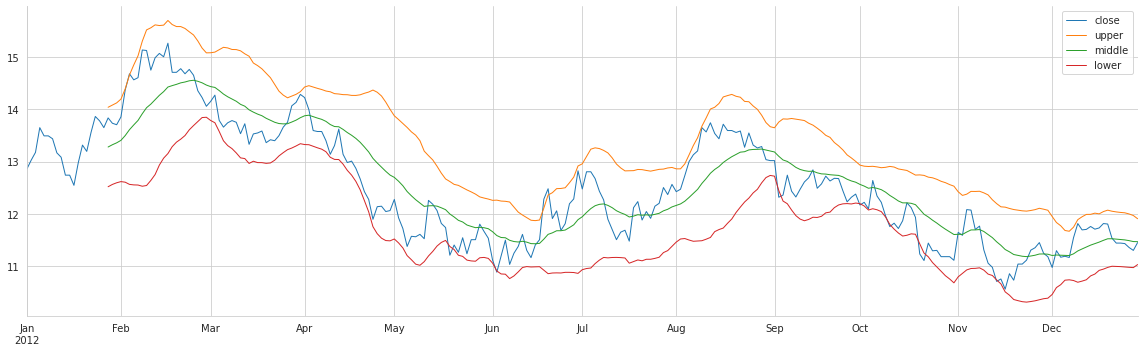

In [ ]:
bb_bands = ['upper', 'middle', 'lower']
# df = price_sample.loc['2012', ['close']]
df = df.assign(**dict(zip(bb_bands, s))) #add 3 new columns to df, named upper, middle lower
ax = df.loc[:, ['close'] + bb_bands].plot(figsize=(16, 5), lw=1)
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

## Building on TALib Indicators: normalized bands and squeeze

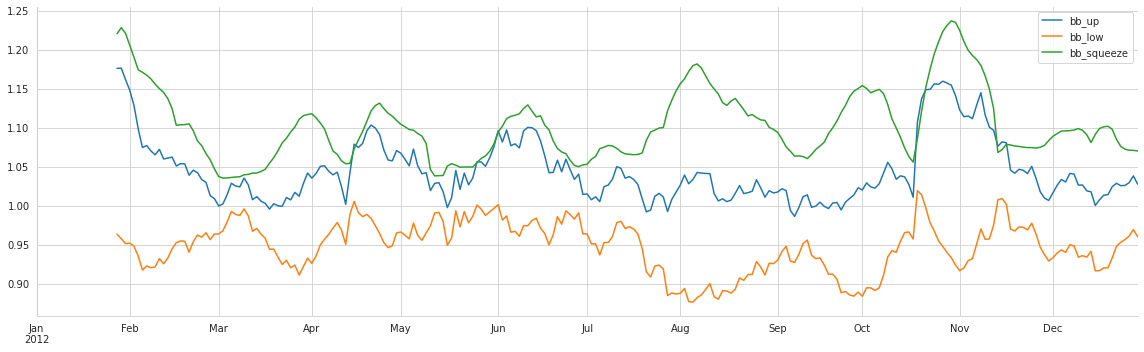

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))
df.upper.div(df.close).plot(ax=ax, label='bb_up')
df.lower.div(df.close).plot(ax=ax, label='bb_low')
df.upper.div(df.lower).plot(ax=ax, label='bb_squeeze', rot=0)

plt.legend()
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

In [ ]:
def compute_bb_indicators(close, timeperiod=20, matype=0):
    high, mid, low = talib.BBANDS(close, 
                                  timeperiod=20,
                                  matype=matype)
    bb_up = high / close -1 # normalize with respect to close
    bb_low = low / close -1 # normalize with respect to close
    squeeze = (high - low) / close
    return pd.DataFrame({'bb_up': bb_up, 
                         'bb_low': bb_low, 
                         'bb_squeeze': squeeze}, 
                        index=close.index)

In [ ]:
data = (data.join(data
                  .groupby(level='ticker')
                  .close
                  .apply(compute_bb_indicators)))

# Hilbert Transform - Instantaneous Trendline

The Hilbert Transform generates inphase and quadrature components of a de-trended real-valued signal like a price series to analyze variations of the instantaneous phase and amplitude.

HTTrendline returns the price series value after the Dominant Cycle of the analytic signal as generated by the Hilbert Transform has been removed. The Dominant Cycle can be thought of as being the "most likely" period (in the range of 10 to 40) of a sine function of the Price Series. See [here](http://www2.wealth-lab.com/WL5Wiki/HTTrendLine.ashx) for additional detail on computation.

In [ ]:
data['ht'] = (data
              .groupby(level='ticker', group_keys=False)
              .close
              .apply(talib.HT_TRENDLINE)
              .div(data.close).sub(1))

## Momentum Indicators

## Parabolic SAR

The Parabolic SAR aims to identify trend reversals. It is a trend-following (lagging) indicator that can be used to set a trailing stop loss or determine entry or exit points. It is usually represented in a price chart as a set of dots near the price bars. Generally, when these dots are above the price, it signals a downward trend, and an upward trend if the dots are below the price. The change in the direction of the dots can be interpreted as a  trade signal. However, the indicator is not as reliable in a flat or range-bound markt. It is compute as follows:

$$\text{SAR}_t=\text{SAR}_{t-1} + \alpha (\text{EP}-\text{SAR}_{t-1})$$

EP (the extreme point) is a record kept during each trend that represents the highest value reached by the price during the current uptrend – or lowest value during a downtrend. During each period, if a new maximum (or minimum) is observed, the EP is updated with that value.

The α value represents the acceleration factor and is typically set initially to a value of 0.02. This factor increases by α each time a new EP is recorded. The rate will then quicken to a point where the SAR converges towards the price. To prevent it from getting too large, a maximum value for the acceleration factor is normally set to 0.20.

For additional detail, see [wikipedia](https://en.wikipedia.org/wiki/Parabolic_SAR); there is also an [extended SAR](http://www.tadoc.org/indicator/SAR.htm).

In [ ]:
df = price_sample.loc['2012', ['close', 'high', 'low']]
df['SAR'] = talib.SAR(df.high, df.low, 
                      acceleration=0.02, # common value
                      maximum=0.2)       

NameError: ignored

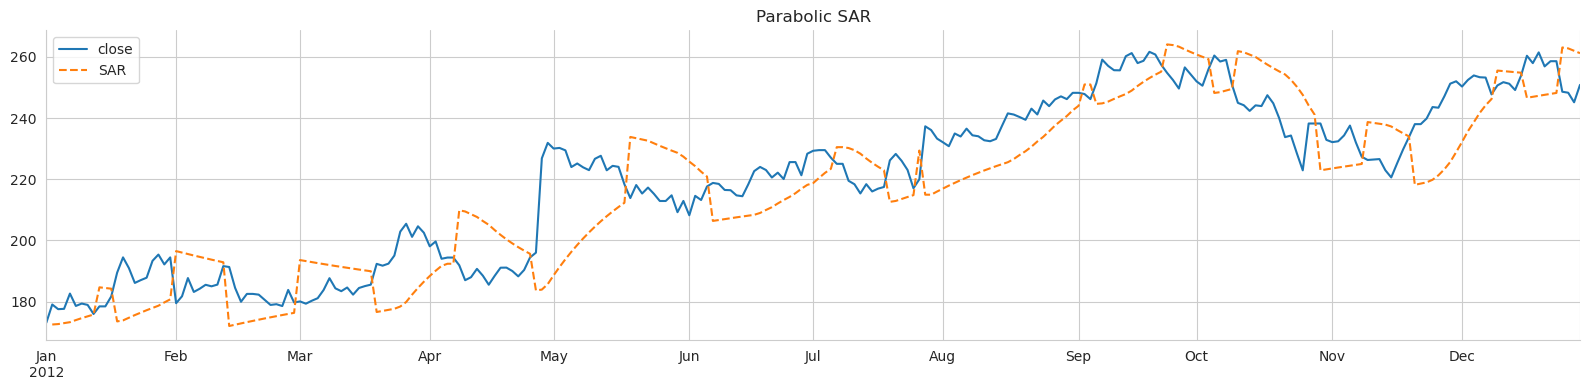

In [ ]:
ax = df[['close', 'SAR']].plot(figsize=(16, 4), style=['-', '--'], title='Parabolic SAR')
ax.set_xlabel('')
sns.despine()
plt.tight_layout();

### Normalized SAR indicator

In [ ]:
def compute_sar_indicator(x, acceleration=.02, maximum=0.2):
    sar = talib.SAR(x.high, 
                    x.low,
                    acceleration=acceleration,
                    maximum=maximum)
    return sar/x.close - 1

In [ ]:
data['sar'] = (data.groupby(level='ticker', group_keys=False)
                  .apply(compute_sar_indicator))

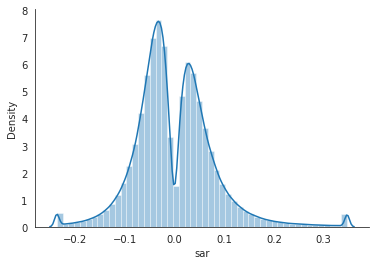

In [ ]:
q=0.005
with sns.axes_style('white'):
    sns.distplot(data.sar.clip(data.sar.quantile(q), data.sar.quantile(1-q)))
    sns.despine()

|Function|             Name|
|:---|:---|
|TRANGE|               True Range|
|ATR|                  Average True Range|
|NATR|                 Normalized Average True Range|

### ATR

The Average True Range indicator (ATR) shows volatility of the market. It was introduced by Welles Wilder (1978)  and has been used as a component of numerous other indicators since. It aims to anticipate changes in trend such that the higher its value, the higher the probability of a trend change; the lower the indicator’s value, the weaker the current trend.

It is computed as the simple moving average for a period T of the True Range (TRANGE), which measures volatility as the absolute value of the largest recent trading range:
$$
\text{TRANGE}_t = \max\left[P_t^\text{High} - P_t^\text{low}, \left| P_t^\text{High} - P_{t-1}^\text{Close}\right|, \left| P_t^\text{low} - P_{t-1}^\text{Close}\right|\right]
$$

In [ ]:
def compute_atr(df):
    atr = talib.ATR(df.high, df.low, df.close, 14)
    return pd.DataFrame({'ATR': atr}, 
                        index=df.close.index)
data = (data.combine_first(data
                  .groupby(level='ticker')
                  .apply(compute_atr)))

In [ ]:
data.loc['MSFT']

,close,high,hl_1,hl_21,hl_252,hl_5,hl_63,low,open,ret_01,ret_03,ret_05,ret_10,ret_126,ret_21,ret_252,ret_42,ret_63,ret_fwd,volume,ht,SAR,sar
date,,,,,,,,,,,,,,,,,,,,,,,
2006-01-03,20.354,20.476,0.821,NaN,NaN,NaN,NaN,19.793,19.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005,79973000.0,NaN,NaN,NaN
2006-01-04,20.452,20.536,0.645,NaN,NaN,NaN,NaN,20.301,20.301,0.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001,57975600.0,NaN,-0.032222,-0.032222
2006-01-05,20.468,20.574,0.364,NaN,NaN,NaN,NaN,20.407,20.422,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.003,48245500.0,NaN,-0.032252,-0.032252
2006-01-06,20.407,20.475,0.824,NaN,NaN,NaN,NaN,20.088,20.384,-0.003,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002,100963000.0,NaN,-0.027858,-0.027858
2006-01-09,20.369,20.528,0.323,NaN,NaN,0.738,NaN,20.293,20.422,-0.002,-0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005,55625000.0,NaN,-0.024600,-0.024600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-22,62.168,62.706,0.209,0.896,0.968,0.723,0.933,62.026,62.452,0.000,-0.001,0.016,0.042,0.292,0.040,0.170,0.049,0.114,-0.005,22176585.0,-0.027653,-0.023222,-0.023222
2016-12-23,61.865,62.158,0.595,0.838,0.950,0.488,0.895,61.434,62.070,-0.005,-0.005,0.015,0.020,0.323,0.047,0.167,0.044,0.119,0.001,12403819.0,-0.018883,-0.012672,-0.012672
2016-12-27,61.904,62.677,0.081,0.845,0.952,0.369,0.899,61.835,61.835,0.001,-0.004,-0.005,0.018,0.296,0.045,0.162,0.051,0.099,-0.005,11763173.0,-0.016597,-0.008569,-0.008569


### NATR

The Normalized Average True Range (NATR) is a normalized version of the ATR computed as follows:

$$
\text{NATR}_t = \frac{\text{ATR}_t(T)}{P_t^\text{Close}} * 100
$$

Normalization make the ATR function more relevant in the folllowing scenarios:
- Long term analysis where the price changes drastically.
- Cross-market or cross-security ATR comparison.

In [ ]:
def compute_natr(df):
    atr = talib.NATR(df.high, df.low, df.close, 14)
    return pd.DataFrame({'natr': atr}, 
                        index=df.close.index)
data = (data.combine_first(data
                  .groupby(level='ticker')
                  .apply(compute_natr)))

# Rounding and Persisting

In [ ]:
data = data.round(decimals = 4)
data = (data
        .drop(['open', 'high', 'low', 'close', 'volume'], axis=1)
        .replace((np.inf, -np.inf), np.nan))

In [ ]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1402295 entries, ('A', Timestamp('2006-01-03 00:00:00')) to ('ZMH', Timestamp('2015-07-02 00:00:00'))
Data columns (total 34 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   db_bear      1402295 non-null  float64
 1   db_bear_ema  1400295 non-null  float64
 2   db_bull      1402295 non-null  float64
 3   db_bull_ema  1400295 non-null  float64
 4   dir10x       1402295 non-null  float64
 5   ema_stack    1402295 non-null  float64
 6   ema_stack2   1402295 non-null  float64
 7   hl_1         1402112 non-null  float64
 8   hl_21        1392221 non-null  float64
 9   hl_252       1276795 non-null  float64
 10  hl_5         1400184 non-null  float64
 11  hl_63        1371272 non-null  float64
 12  holb         1401795 non-null  float64
 13  holb_d       1399795 non-null  float64
 14  ht           1370795 non-null  float64
 15  kpos         1392795 non-null  float64
 16  lohb         14017

In [ ]:
with pd.HDFStore('drive/MyDrive/Colab Notebooks/data/features.h5') as store:
    store.put('model_data', data)

# Sample Data

In [1]:
sample = data.loc['GOOGL']
#sample = data.loc['MSFT']
#sample = data.loc['TIF']
sample.loc['2016-6-23' : '2016-7-7']
#sample.loc['2014-02-26' : '2014-03-20']

NameError: ignored